In [26]:
import pandas as pd
import numpy as np
import pathlib
import os
import sys
import glob
import tensorflow as tf
# from tensorflow.keras.applications.inception_v3 import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from IPython.display import Image, display
import cv2
import json
%matplotlib inline

In [27]:
print(tf.__version__)

2.0.0


## Preprocess data

In [28]:
data_path = "../data"
# city = "gz"
city = "general"
# data_city_path = data_path+ "/"+city

# data_p = pathlib.Path(data_city_path)

In [29]:
meta_table = pd.read_csv("../_"+city+"_filename_dict.csv")
# meta_table = pd.read_csv("../_general_filename_dict.csv")

In [30]:
# Filter is_readable_image == False
f_table = meta_table[(meta_table['is_readable_image']) & (meta_table['is_completed_image'])].copy()
# f_table = f_table[f_table['_format'] != ".gif"].copy()
f_table.reset_index(drop=True, inplace=True)
f_table.fillna("", inplace=True)

In [31]:
f_table['sample'].value_counts()


selfie    3000
皮鞋         157
虾          157
糖果         156
纽扣电池       154
          ... 
金属元件        52
刀具          52
金属衣架        52
烟头          51
家养植物         7
Name: sample, Length: 230, dtype: int64

In [32]:
f_table['level0'].value_counts()

可回收物    5969
有害垃圾    3985
湿垃圾     3703
人像      3000
干垃圾     2407
其他垃圾    2143
厨余垃圾     995
Name: level0, dtype: int64

In [33]:
f_table['general_level0'].value_counts()

可回收物    5969
厨余垃圾    4698
其他垃圾    4550
有害垃圾    3985
人像      3000
Name: general_level0, dtype: int64

In [34]:
f_table.head()

,_filename,_format,sample,spider_id,city,level0,level1,is_readable_image,is_completed_image,general_level0
0,其他垃圾_水果硬壳_椰子壳_37.jpg,.jpg,椰子壳,37,gz,其他垃圾,水果硬壳,True,True,其他垃圾
1,其他垃圾_混杂_土培植物_26.jpg,.jpg,土培植物,26,gz,其他垃圾,混杂,True,True,其他垃圾
2,厨余垃圾_糖果糕点_糖果_25.jpg,.jpg,糖果,25,gz,厨余垃圾,糖果糕点,True,True,厨余垃圾
3,其他垃圾_坚果_核桃壳_28.jpg,.jpg,核桃壳,28,gz,其他垃圾,坚果,True,True,其他垃圾
4,其他垃圾_废旧衣服及其他纺织品_内衣裤_46.jpg,.jpg,内衣裤,46,gz,其他垃圾,废旧衣服及其他纺织品,True,True,其他垃圾


In [35]:
# target_label = "sample"
# target_label = "level0"
target_label = "general_level0"
# filenames = ['../data/' + fname for fname in f_table['_filename'].tolist()]
filenames = [data_path + "/" +fname for fname in (f_table['city'] + "/" +f_table['_filename']).tolist()]
lv0_labels = f_table[target_label].tolist()

In [36]:
labelencoder = preprocessing.LabelEncoder()
lv0_labels_encoded = labelencoder.fit_transform(lv0_labels)

In [37]:
# print(labelencoder.transform(['可回收物', "有害垃圾", "湿垃圾", "干垃圾", "人像"]))
# print(len(labelencoder.classes_))
lv0_n_classes = len(labelencoder.classes_)
level0_label_dict = {k:v for k,v in enumerate(labelencoder.classes_)}

In [38]:
print(labelencoder.classes_)
print(level0_label_dict)

['人像' '其他垃圾' '厨余垃圾' '可回收物' '有害垃圾']
{0: '人像', 1: '其他垃圾', 2: '厨余垃圾', 3: '可回收物', 4: '有害垃圾'}


In [39]:
raw_filenames, test_filenames, raw_labels, test_labels = train_test_split(filenames
                                                                        , lv0_labels_encoded
                                                                        , train_size=0.9
                                                                        , random_state=42)

train_filenames, val_filenames, train_labels, val_labels = train_test_split(raw_filenames
                                                                        , raw_labels
                                                                        , train_size=0.9
                                                                        , random_state=42)

In [40]:
print(len(train_filenames), len(train_labels))
print(len(val_filenames), len(val_labels))
print(len(test_filenames), len(test_labels))

17982 17982
1999 1999
2221 2221


In [41]:
# basenetwork = "inception"
basenetwork = "mobilenet"

In [42]:
# Inception V3 299
if basenetwork == "inception":
    IMAGE_SIZE = 299
elif basenetwork == "mobilenet":
    IMAGE_SIZE = 224
# Mobilenet use 128
# IMAGE_SIZE = 128
BATCH_SIZE = 32
print(IMAGE_SIZE, BATCH_SIZE)

224 32


In [43]:
train_data = tf.data.Dataset.from_tensor_slices(
  (tf.constant(train_filenames), tf.constant(train_labels))
)
val_data = tf.data.Dataset.from_tensor_slices(
  (tf.constant(val_filenames), tf.constant(val_labels))
)

In [44]:
def _parse_fn(filename, label):
    try:
        # read file as byte
        image_string = tf.io.read_file(filename)
        # decode as string 
        image_decoded = tf.image.decode_jpeg(image_string, channels=3)
        # image_decoded = tf.image.decode_gif(image_string)
        ## P.S tf.image.decode_image return shapeless tensor.
        # image_decoded = tf.image.decode_image(image_string)
        
        # resize to given image size
        image_resized = tf.image.resize(image_decoded, (IMAGE_SIZE, IMAGE_SIZE))
        # normailization
        image_normalized = (tf.cast(image_resized, tf.float32)/127.5) - 1
    
        return image_normalized, label
        """image_casted = tf.cast(image_decoded, tf.float32)
        image_resized = tf.image.resize(image_casted, (IMAGE_SIZE, IMAGE_SIZE))
        image_preproc = tf.keras.applications.inception_v3.preprocess_input(image_resized)
        
        return image_preproc, label"""
    
    except Exception as e:
        print(e)
        print(filename)

In [45]:
train_data = (train_data.map(_parse_fn)\
            # .shuffle(buffer_size=5000)\
            .batch(BATCH_SIZE)
             )

val_data = (val_data.map(_parse_fn)
           # .shuffle(buffer_size=5000)
           .batch(BATCH_SIZE)
           )

## Define the model

In [46]:
FINE_TUNE = True

In [47]:
# Base model with InceptionV3
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

if basenetwork == "inception":
    base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')
elif basenetwork == "mobilenet":
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')



if FINE_TUNE:
    # Unfreeze all layers of MobileNetV2
    base_model.trainable = True

    # Refreeze layers until the layers we want to fine-tune
    for layer in base_model.layers[:75]:
        layer.trainable =  False
else:
    base_model.trainable = False

In [48]:
# Trainable classification head
maxpool_layer = tf.keras.layers.GlobalMaxPooling2D()
avgpool_layer = tf.keras.layers.GlobalAveragePooling2D()
# dense_layer = tf.keras.layers.Dense(1024, activation='relu')
dropout_layer = tf.keras.layers.Dropout(0.5)
prediction_layer = tf.keras.layers.Dense(lv0_n_classes, activation='softmax')

learning_rate = 0.0001

model = tf.keras.Sequential([
    base_model
    # mobilenetV2
    , avgpool_layer
    # , maxpool_layer
    # , dense_layer
    , dropout_layer
    , prediction_layer
])

# Now the optimizer is under tf.keras.
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=learning_rate)
    # optimizer=tf.keras.optimizers.SGD(lr=learning_rate, momentum=0.9)
    ## Onehot encoding use categorical_crossentropy
    # , loss='categorical_crossentropy'
    ## Integer encoding, use sparse_categorical_crossentropy
    , loss='sparse_categorical_crossentropy'
    , metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 2,074,117
Non-trainable params: 190,272
_________________________________________________________________


## Train model

In [49]:
num_epochs = 10
steps_per_epoch = round(len(train_filenames))//BATCH_SIZE
val_steps = 20
count = 0

In [59]:
count += 1
history = model.fit(train_data.repeat(),
                    epochs=num_epochs,
                    steps_per_epoch = steps_per_epoch,
                    validation_data=val_data.repeat(), 
                    validation_steps=val_steps)

Train for 561 steps, validate for 20 steps
Epoch 1/10
561/561 [==============================] - 57s 102ms/step - loss: 0.0280 - accuracy: 0.9912 - val_loss: 1.5499 - val_accuracy: 0.7937
Epoch 2/10
561/561 [==============================] - 58s 103ms/step - loss: 0.0240 - accuracy: 0.9918 - val_loss: 1.8296 - val_accuracy: 0.7203
Epoch 3/10
561/561 [==============================] - 58s 104ms/step - loss: 0.0384 - accuracy: 0.9877 - val_loss: 1.6998 - val_accuracy: 0.7563
Epoch 4/10
561/561 [==============================] - 58s 104ms/step - loss: 0.0267 - accuracy: 0.9906 - val_loss: 1.6647 - val_accuracy: 0.7594
Epoch 5/10
561/561 [==============================] - 58s 104ms/step - loss: 0.0273 - accuracy: 0.9911 - val_loss: 1.8148 - val_accuracy: 0.7609
Epoch 6/10
561/561 [==============================] - 58s 104ms/step - loss: 0.0328 - accuracy: 0.9888 - val_loss: 1.7769 - val_accuracy: 0.7625
Epoch 7/10
561/561 [==============================] - 58s 104ms/step - loss: 0.0204 - a

### Save the model

In [60]:
print(target_label, count * num_epochs)
if basenetwork == "inception":
    base_model_name = "inceptionV3"
elif basenetwork == "mobilenet":
    base_model_name = "mobilenetV2"
save_name = "../models/_"+city+"_"+base_model_name+"_epoch" + str(count * num_epochs) + "_dropout05_" + target_label + ".h5"
# save_name = "../models/_mobilenet_epoch_" + str(count * num_epochs) + "_without_dropout_" + target_label + ".h5"

print(save_name)
print(os.path.basename(save_name))

general_level0 20
../models/_general_mobilenetV2_epoch20_dropout05_general_level0.h5
_general_mobilenetV2_epoch20_dropout05_general_level0.h5


In [52]:
# Save model weights
# model.save_weights('../models/weights_epoch_30_nodrop_out.h5')
model.save(save_name)

In [53]:
model_label_dict_conf = "../models/model_label_dict.json"
if os.path.exists(model_label_dict_conf) and os.stat(model_label_dict_conf).st_size != 0:
    with open(model_label_dict_conf, 'r') as f:
        _save_params = json.loads(f.read())
        # print(_save_params)
else:
    _save_params = {}

In [54]:
_save_params

{'sh': {'_inceptionV3_epoch_30_without_dropout_level0': {'model_name': '_inceptionV3_epoch_30_without_dropout_level0.h5',
   'label_dict': {'0': '人像', '1': '可回收物', '2': '干垃圾', '3': '有害垃圾', '4': '湿垃圾'},
   'IMAGE_SIZE': 299},
  '_mobilenetV2_epoch_30_without_dropout_level0': {'model_name': '_mobilenetV2_epoch_30_without_dropout_level0.h5',
   'label_dict': {'0': '人像', '1': '可回收物', '2': '干垃圾', '3': '有害垃圾', '4': '湿垃圾'},
   'IMAGE_SIZE': 224},
  '_inceptionV3_epoch_30_without_dropout_sample': {'model_name': '_inceptionV3_epoch_30_without_dropout_sample.h5',
   'label_dict': {'0': 'selfie',
    '1': 'x光片',
    '2': '一次性餐具',
    '3': '中药材',
    '4': '书包',
    '5': '书本',
    '6': '乳液罐',
    '7': '伞',
    '8': '信封',
    '9': '充电电池',
    '10': '光管',
    '11': '内脏',
    '12': '刀',
    '13': '刀片',
    '14': '医疗废品',
    '15': '卤素灯',
    '16': '卫生间用纸',
    '17': '咖啡渣',
    '18': '塑料瓶',
    '19': '大骨头',
    '20': '太空沙',
    '21': '宠物饲料',
    '22': '家养植物',
    '23': '尼龙制品',
    '24': '尿不湿',
    '25':

In [55]:
_city_params = _save_params.get(city, {})
if _city_params:
    if os.path.splitext(os.path.basename(save_name))[0] in _city_params.keys():
        _city_param = _city_params[os.path.splitext(os.path.basename(save_name))[0]]
    else:
        _city_param = {}

    _city_param['model_name'] = os.path.basename(save_name)
    _city_param['label_dict'] = level0_label_dict
    _city_param['IMAGE_SIZE'] = IMAGE_SIZE
    _city_params[os.path.splitext(os.path.basename(save_name))[0]] = _city_param
    _save_params[city] = _city_params
else:
    _city_param = {}
    _city_param['model_name'] = os.path.basename(save_name)
    _city_param['label_dict'] = level0_label_dict
    _city_param['IMAGE_SIZE'] = IMAGE_SIZE
    _city_params[os.path.splitext(os.path.basename(save_name))[0]] = _city_param
    _save_params[city] = _city_params

In [56]:
_save_params

{'sh': {'_inceptionV3_epoch_30_without_dropout_level0': {'model_name': '_inceptionV3_epoch_30_without_dropout_level0.h5',
   'label_dict': {'0': '人像', '1': '可回收物', '2': '干垃圾', '3': '有害垃圾', '4': '湿垃圾'},
   'IMAGE_SIZE': 299},
  '_mobilenetV2_epoch_30_without_dropout_level0': {'model_name': '_mobilenetV2_epoch_30_without_dropout_level0.h5',
   'label_dict': {'0': '人像', '1': '可回收物', '2': '干垃圾', '3': '有害垃圾', '4': '湿垃圾'},
   'IMAGE_SIZE': 224},
  '_inceptionV3_epoch_30_without_dropout_sample': {'model_name': '_inceptionV3_epoch_30_without_dropout_sample.h5',
   'label_dict': {'0': 'selfie',
    '1': 'x光片',
    '2': '一次性餐具',
    '3': '中药材',
    '4': '书包',
    '5': '书本',
    '6': '乳液罐',
    '7': '伞',
    '8': '信封',
    '9': '充电电池',
    '10': '光管',
    '11': '内脏',
    '12': '刀',
    '13': '刀片',
    '14': '医疗废品',
    '15': '卤素灯',
    '16': '卫生间用纸',
    '17': '咖啡渣',
    '18': '塑料瓶',
    '19': '大骨头',
    '20': '太空沙',
    '21': '宠物饲料',
    '22': '家养植物',
    '23': '尼龙制品',
    '24': '尿不湿',
    '25':

In [57]:
with open("../models/model_label_dict.json", "w") as f:
    _save_param_str = json.dumps(_save_params)
    f.write(_save_param_str)

### Take a look on Accuracy and Loss curve.

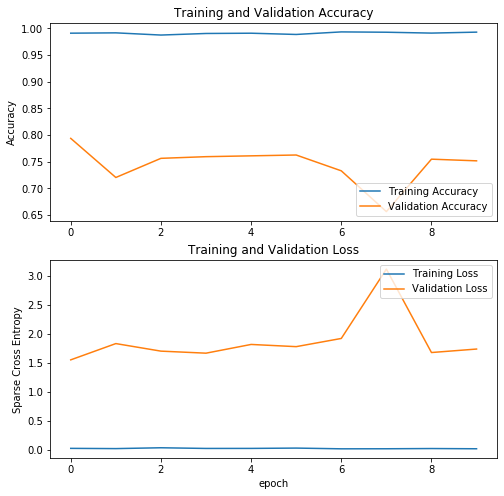

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Sparse Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [63]:
def _preprocess_imagefile(filename):
    try:
        # read file as byte
        image_string = tf.io.read_file(filename)
        # decode as string 
        image_decoded = tf.image.decode_jpeg(image_string, channels=3)
        # image_decoded = tf.image.decode_gif(image_string)
        ## P.S tf.image.decode_image return shapeless tensor.
        # image_decoded = tf.image.decode_image(image_string)
        
        # resize to given image size
        image_resized = tf.image.resize(image_decoded, (IMAGE_SIZE, IMAGE_SIZE))
        # normailization
        image_normalized = (tf.cast(image_resized, tf.float32)/127.5) - 1
    
        return image_normalized
        """image_casted = tf.cast(image_decoded, tf.float32)
        image_resized = tf.image.resize(image_casted, (IMAGE_SIZE, IMAGE_SIZE))
        image_preproc = tf.keras.applications.inception_v3.preprocess_input(image_resized)
        
        return image_preproc, label"""
    
    except Exception as e:
        print(e)
        print(filename)

### Input some test sample to test

In [64]:
random_filename = np.random.choice(test_filenames)
print(random_filename)
basename = random_filename.split("/")[-1].split(".")[0]
name_seg = basename.split("_")
sub_id = name_seg.pop()
sample = name_seg.pop()
labels = {"level"+str(i):l for i,l in enumerate(name_seg)}
print(labels['level0'])
random_x = _preprocess_imagefile(random_filename)
# print(random_x)
pred_y = model.predict(tf.expand_dims(random_x, axis=0))
print(pred_y)
print(labelencoder.classes_[pred_y.argmax()])

../data/gz/有害垃圾_废灯管类_节能灯_41.jpg
有害垃圾
[[9.7994867e-04 1.1168985e-02 2.3901509e-04 1.4475660e-01 8.4285545e-01]]
有害垃圾
